In [70]:
from functools import partial

import numpy as np
import jax
import jax.numpy as jnp
from jax.flatten_util import ravel_pytree

import matplotlib.pyplot as plt

from scipy.optimize import minimize

import collimator
from collimator.simulation import SimulatorOptions
from collimator.models import CompassGait, RimlessWheel, VanDerPol

from tqdm import tqdm

In [3]:
model = CompassGait()
context = model.create_context()

In [ ]:
# Generate a valid initial condition using the reset map.
xs = []
toes = []
stances = []
ts = []

var_vals = np.linspace(-0.5, 0.5, 5)

for var1 in tqdm(var_vals):
    for var2 in var_vals:
        for var3 in var_vals:
            for var4 in var_vals:
                x0 = jnp.array([var1, var2, var3, var4])
                context = context.with_continuous_state(x0)

                # Note we want to limit the major step length here to avoid skipping over the collision
                options = SimulatorOptions(
                    max_major_step_length=0.5,
                    max_major_steps=400,
                    atol=1e-14,
                    rtol=1e-12,
                )
                recorded_signals = {
                    "xc": model.output_ports[0],
                    "toe": model.output_ports[1],
                    "stance": model.output_ports[2],
                }
                results = collimator.simulate(
                    model,
                    context,
                    (0.0, 5.0),
                    options=options,
                    recorded_signals=recorded_signals,
                )

                t = results.time
                xc = results.outputs["xc"]
                toe = results.outputs["toe"]
                stance = results.outputs["stance"]
                
                ts.append(t)
                xs.append(xc)
                toes.append(toe)
                stances.append(stance)

In [68]:
# xs = np.array(xs)
np.save("data/rimless_wheel.npy", xs)

In [ ]:
from IPython import display

save = []

for idx, x in enumerate(xs):
    plt.plot(x[:, 0])
    plt.show()
    display.clear_output(wait=True)
    text = input("Save?")
    if text == "1":
        save.append(idx)


(array([-250, -249, -248, -247, -246, -245, -244, -243, -242, -241, -240,
        -239, -238, -237, -236, -235, -234, -233, -232, -231, -230, -229,
        -228, -227, -226, -225, -224, -223, -222, -221, -220, -219, -218,
        -217, -216, -215, -214, -213, -212, -211, -210, -209, -208, -207,
        -206, -205, -204, -203, -202, -201, -200, -199, -198, -197, -196,
        -195, -194, -193, -192, -191, -190, -189, -188, -187, -186, -185,
        -184, -183, -182, -181, -180, -179, -178, -177, -176, -175, -174,
        -173, -172, -171, -170, -169, -168, -167, -166, -165, -164, -163,
        -162, -161, -160, -159, -158, -157, -156, -155, -154, -153, -152,
        -151, -150, -149, -148, -147, -146, -145, -144, -143, -142, -141,
        -140, -139, -138, -137, -136, -135, -134, -133, -132, -131, -130,
        -129, -128, -127, -126, -125, -124, -123, -122, -121, -120, -119,
        -118, -117, -116, -115, -114, -113, -112, -111, -110, -109, -108,
        -107, -106, -105, -104, -103, 

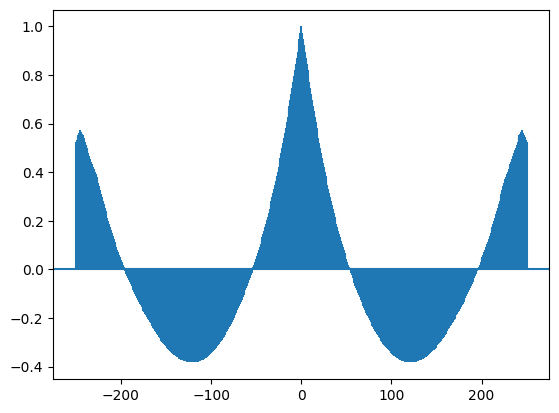

In [34]:
plt.acorr(xc[:, 0], maxlags=250)

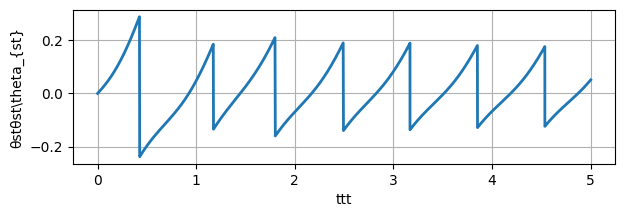

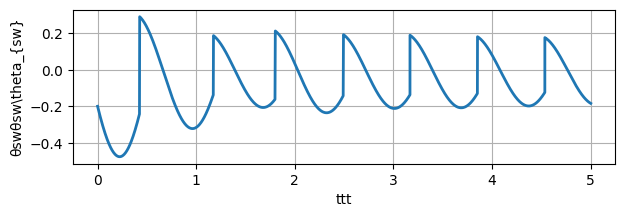

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(7, 2))
ax.plot(t, xc[:, 0], lw=2)
ax.set_xlabel(r"ttt")
ax.set_ylabel(r"θstθst\theta_{st}")
ax.grid()
plt.show()


fig, ax = plt.subplots(1, 1, figsize=(7, 2))
ax.plot(t, xc[:, 1], lw=2)
ax.set_xlabel(r"ttt")
ax.set_ylabel(r"θswθsw\theta_{sw}")
ax.grid()
plt.show()

<Figure size 400x400 with 0 Axes>

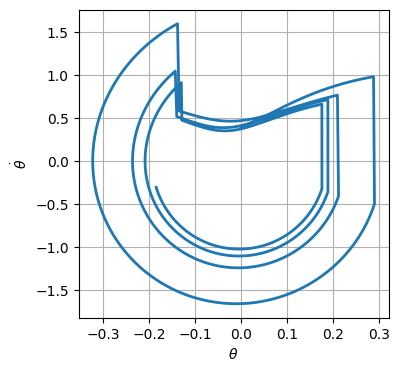

In [22]:
t = results.time
xc = results.outputs["xc"]
toe = results.outputs["toe"]
stance = results.outputs["stance"]
p = results.context.parameters

model.plot_trajectory(xc, stance)

In [14]:
# try:
# NOTE: You need IPython and ffmpeg installed to create the animation
# also may need to point to your local ffmpeg path: `which ffmpeg`
plt.rcParams["animation.ffmpeg_path"] = "/usr/bin/ffmpeg"

model.animate(
    t, xc, toe, stance, p, xlim=(-1, 6), ylim=(-1.0, 1.5), dt=0.05, ramp_color="k"
)

# except:
#     print(
#         "Could not create animation.  Make sure ffmpeg is installed and available to matplotlib."
#     )

In [6]:
model = CompassGait()
context = model.create_context()

In [7]:
# Define a function to compute the difference between the final and initial state
def shoot(model, context, unflatten, vec):
    xc0, tf = unflatten(vec)
    context = context.with_continuous_state(xc0)
    xd0 = model.DiscreteStateType(toe=0.0, left_leg_is_stance=False)
    context = context.with_discrete_state(xd0)

    # Run simulation
    options = SimulatorOptions(
        enable_autodiff=True,
        max_major_step_length=0.5,
        max_major_steps=400,
        atol=1e-14,
        rtol=1e-12,
    )
    results = collimator.simulate(model, context, (0.0, tf), options=options)
    xf = results.context.continuous_state
    return jnp.linalg.norm(xf - xc0) ** 2


tf0 = 0.7
vec, unflatten = ravel_pytree((x0, tf0))
shoot(model, context, unflatten, vec)

collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=0.5, max_major_steps=400, ode_solver_method=default, rtol=1e-12, atol=1e-14, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=False, recorded_signals=0, return_context=True), Dopri5Solver(system=CompassGait(system_id=2, name='CompassGait_2_', ui_id=None, parent=None), rtol=1e-12, atol=1e-14, max_step_size=None, min_step_size=None, method='default', enable_autodiff=True)


Array(0.24345888, dtype=float64)

In [8]:
func = jax.jit(partial(shoot, model, context, unflatten))

# Solve the problem using scipy minimize
res = minimize(func, vec, jac=jax.jacrev(func), method="BFGS")
x_opt, tf_opt = unflatten(res.x)
res

collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=0.5, max_major_steps=400, ode_solver_method=default, rtol=1e-12, atol=1e-14, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=False, recorded_signals=0, return_context=True), Dopri5Solver(system=CompassGait(system_id=2, name='CompassGait_2_', ui_id=None, parent=None), rtol=1e-12, atol=1e-14, max_step_size=None, min_step_size=None, method='default', enable_autodiff=True)


  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 4.653079287661414e-13
        x: [-4.324e-02  7.063e-02  2.627e-01 -6.855e-01  7.013e-01]
      nit: 29
      jac: [ 1.444e-06  7.598e-07  1.776e-08 -6.976e-08 -4.356e-07]
 hess_inv: [[ 9.038e-01 -7.475e-01 ...  6.961e+00  5.541e-01]
            [-7.475e-01  1.391e+00 ... -5.818e+00  3.164e-01]
            ...
            [ 6.961e+00 -5.818e+00 ...  8.291e+01  8.515e+00]
            [ 5.541e-01  3.164e-01 ...  8.515e+00  2.097e+00]]
     nfev: 35
     njev: 35

collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=0.5, max_major_steps=400, ode_solver_method=default, rtol=1e-12, atol=1e-14, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=3, return_context=True), Dopri5Solver(system=CompassGait(system_id=2, name='CompassGait_2_', ui_id=None, parent=None), rtol=1e-12, atol=1e-14, max_step_size=None, min_step_size=None, method='default', enable_autodiff=False)


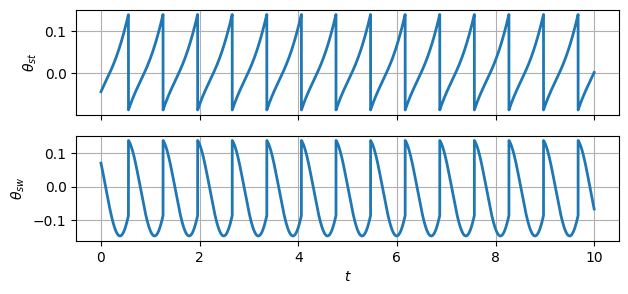

In [9]:
# Note we want to limit the major step length here to avoid skipping over the collision

options = SimulatorOptions(
    max_major_step_length=0.5,
    max_major_steps=400,
    atol=1e-14,
    rtol=1e-12,
)
context = context.with_continuous_state(x_opt)
xd = model.DiscreteStateType(toe=0.0, left_leg_is_stance=False)
context = context.with_discrete_state(xd)

recorded_signals = {
    "xc": model.output_ports[0],
    "toe": model.output_ports[1],
    "stance": model.output_ports[2],
}
results = collimator.simulate(
    model,
    context,
    (0.0, 10.0),
    options=options,
    recorded_signals=recorded_signals,
)

t = results.time
x = results.outputs["xc"]

fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex=True)
ax[0].plot(t, x[:, 0], lw=2)
ax[0].set_ylabel(r"$\theta_{st}$")
ax[0].grid()

ax[1].plot(t, x[:, 1], lw=2)
ax[1].set_xlabel(r"$t$")
ax[1].set_ylabel(r"$\theta_{sw}$")
ax[1].grid()
plt.show()

<Figure size 400x400 with 0 Axes>

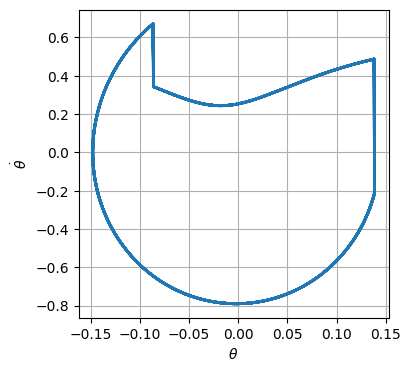

In [10]:
t = results.time
xc = results.outputs["xc"]
toe = results.outputs["toe"]
stance = results.outputs["stance"]
p = results.context.parameters

model.plot_trajectory(xc, stance)

In [13]:
shoot_options = SimulatorOptions(
    enable_autodiff=True,
    max_major_steps=100,
    rtol=1e-12,
    atol=1e-14,
)

def forward_map(model, context, T, x0):
    context = context.with_continuous_state(x0)
    results = collimator.simulate(model, context, (0.0, T), options=shoot_options)
    return results.context.continuous_state


func = jax.jit(partial(forward_map, model, context, tf_opt))

# Jacobian of the forward map
# eigvals <= 1.0 indicate stability of the limit cycle
jac = jax.jacrev(func)(x_opt)

np.linalg.eigvals(jac)

collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=100, ode_solver_method=default, rtol=1e-12, atol=1e-14, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=False, recorded_signals=0, return_context=True), Dopri5Solver(system=CompassGait(system_id=2, name='CompassGait_2_', ui_id=None, parent=None), rtol=1e-12, atol=1e-14, max_step_size=None, min_step_size=None, method='default', enable_autodiff=True)


array([-5.13252684e-01,  2.87829656e-14,  9.99998908e-01,  8.78664775e-01])

## Rimless Wheel

In [3]:
model = RimlessWheel()
context = model.create_context()

collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=1.0, max_major_steps=500, ode_solver_method=default, rtol=1e-12, atol=1e-14, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=2, return_context=True), Dopri5Solver(system=RimlessWheel(system_id=1, name='RimlessWheel_1_', ui_id=None, parent=None), rtol=1e-12, atol=1e-14, max_step_size=None, min_step_size=None, method='default', enable_autodiff=False)


LeafState(xc=[-0.18699956  0.6234898 ], xd=15.619814608232092)


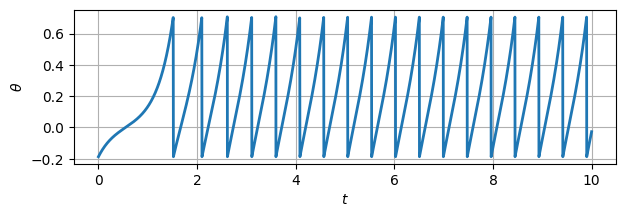

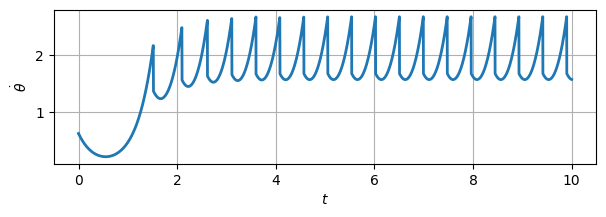

In [38]:
# Generate a valid initial condition using the reset map.
context = context.with_continuous_state(jnp.array([0.0, 1.0]))
context = context.with_state(
    model.downhill_reset(0.0, context.state, **context.parameters)
)
print(context.state)

# Note we want to limit the major step length here to avoid skipping over the collisions
options = SimulatorOptions(
    max_major_step_length=1.0,
    max_major_steps=500,
    atol=1e-14,
    rtol=1e-12,
)
recorded_signals = {
    "xc": model.output_ports[0],
    "toe": model.output_ports[1],
}
results = collimator.simulate(
    model, context, (0.0, 10.0), options=options, recorded_signals=recorded_signals
)

t = results.time
x = results.outputs["xc"]
toe = results.outputs["toe"]
p = results.context.parameters

fig, ax = plt.subplots(1, 1, figsize=(7, 2))
ax.plot(t, x[:, 0], lw=2)
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$\theta$")
ax.grid()
plt.show()


fig, ax = plt.subplots(1, 1, figsize=(7, 2))
ax.plot(t, x[:, 1], lw=2)
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$\dot{\theta}$")
ax.grid()
plt.show()

In [39]:
# try:
    # NOTE: You need IPython and ffmpeg installed to create the animation
    # also may need to point to your local ffmpeg path: `which ffmpeg`
plt.rcParams["animation.ffmpeg_path"] = "/usr/bin/ffmpeg"
model.animate(t, x, toe, p, xlim=(-1, 10), ylim=(-2.5, 2.0), ramp_color="k")

# except:
#     print(
#         "Could not create animation.  Make sure ffmpeg is installed and available to matplotlib."
#     )

In [40]:
# Define a function to compute the difference between the final and initial state


def shoot(model, context, unflatten, vec):
    x0, tf = unflatten(vec)
    context = context.with_continuous_state(x0)
    context = context.with_discrete_state(0.0)

    # Run simulation
    options = SimulatorOptions(
        enable_autodiff=True,
        max_major_step_length=1.0,
        max_major_steps=300,
        atol=1e-14,
        rtol=1e-12,
    )
    results = collimator.simulate(model, context, (0.0, tf), options=options)
    xf = results.context.continuous_state
    return jnp.linalg.norm(xf - x0) ** 2


x0 = jnp.array([0.0, 2.0])
tf0 = 0.5
vec, unflatten = ravel_pytree((x0, tf0))
shoot(model, context, unflatten, vec)

collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=1.0, max_major_steps=300, ode_solver_method=default, rtol=1e-12, atol=1e-14, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=False, recorded_signals=0, return_context=True), Dopri5Solver(system=RimlessWheel(system_id=1, name='RimlessWheel_1_', ui_id=None, parent=None), rtol=1e-12, atol=1e-14, max_step_size=None, min_step_size=None, method='default', enable_autodiff=True)


Array(0.05826542, dtype=float64)

In [41]:
func = jax.jit(partial(shoot, model, context, unflatten))

# Solve the problem using scipy minimize
res = minimize(func, vec, jac=jax.jacrev(func), method="BFGS")
x_opt, tf_opt = unflatten(res.x)
res

collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=1.0, max_major_steps=300, ode_solver_method=default, rtol=1e-12, atol=1e-14, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=False, recorded_signals=0, return_context=True), Dopri5Solver(system=RimlessWheel(system_id=1, name='RimlessWheel_1_', ui_id=None, parent=None), rtol=1e-12, atol=1e-14, max_step_size=None, min_step_size=None, method='default', enable_autodiff=True)


  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 2.5788194679520583e-12
        x: [ 2.851e-01  1.803e+00  4.845e-01]
      nit: 6
      jac: [-1.075e-06  7.025e-07  7.884e-06]
 hess_inv: [[ 1.189e+00 -1.250e-01  6.636e-03]
            [-1.250e-01  1.083e+00 -7.519e-03]
            [ 6.636e-03 -7.519e-03  4.308e-02]]
     nfev: 8
     njev: 8

collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=1.0, max_major_steps=300, ode_solver_method=default, rtol=1e-12, atol=1e-14, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=2, return_context=True), Dopri5Solver(system=RimlessWheel(system_id=1, name='RimlessWheel_1_', ui_id=None, parent=None), rtol=1e-12, atol=1e-14, max_step_size=None, min_step_size=None, method='default', enable_autodiff=False)


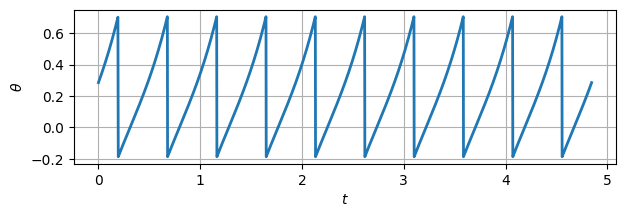

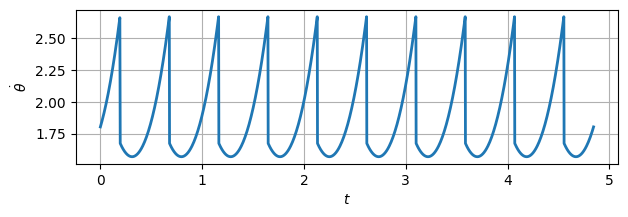

In [42]:
# Note we want to limit the major step length here to avoid skipping over the collision

options = SimulatorOptions(
    max_major_step_length=1.0,
    max_major_steps=300,
    atol=1e-14,
    rtol=1e-12,
)
context = context.with_continuous_state(x_opt)
context = context.with_discrete_state(0.0)

recorded_signals = {
    "xc": model.output_ports[0],
    "toe": model.output_ports[1],
}
results = collimator.simulate(
    model,
    context,
    (0.0, 10 * tf_opt),
    options=options,
    recorded_signals=recorded_signals,
)

t = results.time
x = results.outputs["xc"]

fig, ax = plt.subplots(1, 1, figsize=(7, 2))
ax.plot(t, x[:, 0], lw=2)
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$\theta$")
ax.grid()
plt.show()


fig, ax = plt.subplots(1, 1, figsize=(7, 2))
ax.plot(t, x[:, 1], lw=2)
ax.set_xlabel(r"$t$")
ax.set_ylabel(r"$\dot{\theta}$")
ax.grid()
plt.show()

# model.plot(xf, t_eval)

In [43]:
shoot_options = SimulatorOptions(
    enable_autodiff=True,
    max_major_steps=100,
    rtol=1e-12,
    atol=1e-14,
)

def forward_map(model, context, T, x0):
    context = context.with_continuous_state(x0)
    results = collimator.simulate(model, context, (0.0, T), options=shoot_options)
    return results.context.continuous_state


func = jax.jit(partial(forward_map, model, context, tf_opt))

# Jacobian of the forward map
# eigvals <= 1.0 indicate stability of the limit cycle
jac = jax.jacrev(func)(x_opt)

np.linalg.eigvals(jac)

collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=100, ode_solver_method=default, rtol=1e-12, atol=1e-14, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=False, recorded_signals=0, return_context=True), Dopri5Solver(system=RimlessWheel(system_id=1, name='RimlessWheel_1_', ui_id=None, parent=None), rtol=1e-12, atol=1e-14, max_step_size=None, min_step_size=None, method='default', enable_autodiff=True)


array([0.38873808, 1.00000374])

In [55]:
# Generate a valid initial condition using the reset map.
xs = []
toes = []
ts = []

var_vals1 = np.linspace(-0.5, 0.5, 5)
var_vals2 = np.linspace(1, 3, 5)

for var1 in tqdm(var_vals1):
    for var2 in var_vals2:
        x0 = jnp.array([var1, var2])
        context = context.with_continuous_state(x0)

        # Note we want to limit the major step length here to avoid skipping over the collision
        options = SimulatorOptions(
            max_major_step_length=1.0,
            max_major_steps=500,
            atol=1e-14,
            rtol=1e-12,
        )
        recorded_signals = {
            "xc": model.output_ports[0],
            "toe": model.output_ports[1],
        }
        results = collimator.simulate(
            model,
            context,
            (0.0, 30.0),
            options=options,
            recorded_signals=recorded_signals,
        )

        t = results.time
        xc = results.outputs["xc"]
        toe = results.outputs["toe"]

        ts.append(t)
        xs.append(xc)
        toes.append(toe)

  0%|          | 0/5 [00:00<?, ?it/s]collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=1.0, max_major_steps=500, ode_solver_method=default, rtol=1e-12, atol=1e-14, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=2, return_context=True), Dopri5Solver(system=RimlessWheel(system_id=1, name='RimlessWheel_1_', ui_id=None, parent=None), rtol=1e-12, atol=1e-14, max_step_size=None, min_step_size=None, method='default', enable_autodiff=False)
collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=1.0, max_major_steps=500, ode_solver_method=default, rtol=1e-12, atol=1e-14, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=2, return_context=True), Dopri5Solver(system=RimlessWheel(system_id=1, name='RimlessWheel_1_', ui_id=No

In [67]:
xs = np.array([x[:np.min([x.shape[0] for x in np.array(xs, dtype='object')]), :] for x in xs])

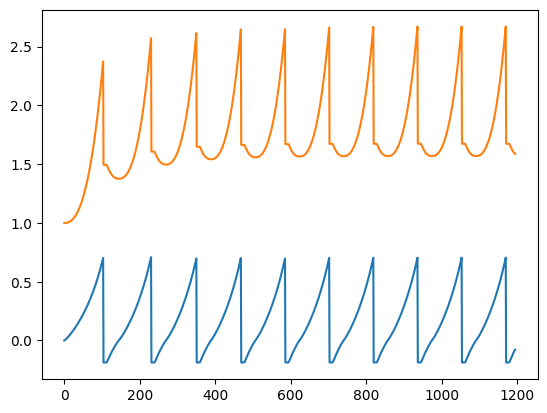

In [62]:
plt.plot(xs[10])

In [75]:
model = VanDerPol(mu=1.0)  # Stable case
context = model.create_context()

In [76]:
func = jax.jit(partial(shoot, model, context, unflatten))

# Solve the problem using scipy minimize
res = minimize(func, vec, jac=jax.jacrev(func), method="BFGS")
x_opt, tf_opt = unflatten(res.x)
print(res)

collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=1.0, max_major_steps=300, ode_solver_method=default, rtol=1e-12, atol=1e-14, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=False, recorded_signals=0, return_context=True), Dopri5Solver(system=VanDerPol(system_id=3, name=..., ui_id=None, parent=None), rtol=1e-12, atol=1e-14, max_step_size=None, min_step_size=None, method='default', enable_autodiff=True)
E0407 00:58:10.375411 1428780 pjrt_stream_executor_client.cc:2809] Execution of replica 0 failed: INTERNAL: CustomCall failed: CpuCallback error: Traceback (most recent call last):
  File "/home/michael/.conda/envs/jax/lib/python3.11/runpy.py", line 198, in _run_module_as_main
  File "/home/michael/.conda/envs/jax/lib/python3.11/runpy.py", line 88, in _run_code
  File "/home/michael/.conda/envs/jax/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module

XlaRuntimeError: INTERNAL: CustomCall failed: CpuCallback error: Traceback (most recent call last):
  File "/home/michael/.conda/envs/jax/lib/python3.11/runpy.py", line 198, in _run_module_as_main
  File "/home/michael/.conda/envs/jax/lib/python3.11/runpy.py", line 88, in _run_code
  File "/home/michael/.conda/envs/jax/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
  File "/home/michael/.conda/envs/jax/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
  File "/home/michael/.conda/envs/jax/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
  File "/home/michael/.conda/envs/jax/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 205, in start
  File "/home/michael/.conda/envs/jax/lib/python3.11/asyncio/base_events.py", line 608, in run_forever
  File "/home/michael/.conda/envs/jax/lib/python3.11/asyncio/base_events.py", line 1936, in _run_once
  File "/home/michael/.conda/envs/jax/lib/python3.11/asyncio/events.py", line 84, in _run
  File "/home/michael/.conda/envs/jax/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 545, in dispatch_queue
  File "/home/michael/.conda/envs/jax/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 534, in process_one
  File "/home/michael/.conda/envs/jax/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 437, in dispatch_shell
  File "/home/michael/.conda/envs/jax/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 362, in execute_request
  File "/home/michael/.conda/envs/jax/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 778, in execute_request
  File "/home/michael/.conda/envs/jax/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 449, in do_execute
  File "/home/michael/.conda/envs/jax/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 549, in run_cell
  File "/home/michael/.conda/envs/jax/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell
  File "/home/michael/.conda/envs/jax/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell
  File "/home/michael/.conda/envs/jax/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
  File "/home/michael/.conda/envs/jax/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async
  File "/home/michael/.conda/envs/jax/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes
  File "/home/michael/.conda/envs/jax/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code
  File "/tmp/ipykernel_1428780/3829711013.py", line 4, in <module>
  File "/home/michael/.conda/envs/jax/lib/python3.11/site-packages/scipy/optimize/_minimize.py", line 691, in minimize
  File "/home/michael/.conda/envs/jax/lib/python3.11/site-packages/scipy/optimize/_optimize.py", line 1388, in _minimize_bfgs
  File "/home/michael/.conda/envs/jax/lib/python3.11/site-packages/scipy/optimize/_optimize.py", line 1160, in _line_search_wolfe12
  File "/home/michael/.conda/envs/jax/lib/python3.11/site-packages/scipy/optimize/_linesearch.py", line 84, in line_search_wolfe1
  File "/home/michael/.conda/envs/jax/lib/python3.11/site-packages/scipy/optimize/_linesearch.py", line 160, in scalar_search_wolfe1
  File "/home/michael/.conda/envs/jax/lib/python3.11/site-packages/scipy/optimize/_linesearch.py", line 75, in phi
  File "/home/michael/.conda/envs/jax/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py", line 267, in fun
  File "/home/michael/.conda/envs/jax/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py", line 251, in _update_fun
  File "/home/michael/.conda/envs/jax/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py", line 155, in update_fun
  File "/home/michael/.conda/envs/jax/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py", line 137, in fun_wrapped
  File "/home/michael/.conda/envs/jax/lib/python3.11/site-packages/jax/_src/traceback_util.py", line 179, in reraise_with_filtered_traceback
  File "/home/michael/.conda/envs/jax/lib/python3.11/site-packages/jax/_src/pjit.py", line 298, in cache_miss
  File "/home/michael/.conda/envs/jax/lib/python3.11/site-packages/jax/_src/pjit.py", line 176, in _python_pjit_helper
  File "/home/michael/.conda/envs/jax/lib/python3.11/site-packages/jax/_src/core.py", line 2788, in bind
  File "/home/michael/.conda/envs/jax/lib/python3.11/site-packages/jax/_src/core.py", line 425, in bind_with_trace
  File "/home/michael/.conda/envs/jax/lib/python3.11/site-packages/jax/_src/core.py", line 913, in process_primitive
  File "/home/michael/.conda/envs/jax/lib/python3.11/site-packages/jax/_src/pjit.py", line 1488, in _pjit_call_impl
  File "/home/michael/.conda/envs/jax/lib/python3.11/site-packages/jax/_src/pjit.py", line 1471, in call_impl_cache_miss
  File "/home/michael/.conda/envs/jax/lib/python3.11/site-packages/jax/_src/pjit.py", line 1427, in _pjit_call_impl_python
  File "/home/michael/.conda/envs/jax/lib/python3.11/site-packages/jax/_src/profiler.py", line 335, in wrapper
  File "/home/michael/.conda/envs/jax/lib/python3.11/site-packages/jax/_src/interpreters/pxla.py", line 1205, in __call__
  File "/home/michael/.conda/envs/jax/lib/python3.11/site-packages/jax/_src/interpreters/mlir.py", line 2466, in _wrapped_callback
  File "/home/michael/.conda/envs/jax/lib/python3.11/site-packages/jax/_src/debugging.py", line 153, in _callback
  File "/home/michael/.conda/envs/jax/lib/python3.11/site-packages/jax/_src/debugging.py", line 89, in debug_callback_impl
  File "/home/michael/.conda/envs/jax/lib/python3.11/site-packages/jax/_src/debugging.py", line 246, in _flat_callback
  File "/home/michael/.conda/envs/jax/lib/python3.11/site-packages/collimator/simulation/simulator.py", line 71, in _raise_end_time_not_reached
RuntimeError: Simulator failed to reach specified end time. End time=-0.3853193476061697. Reached time=0.0. Try increasing Maximum Major Steps.

collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=1000, ode_solver_method=default, rtol=1e-12, atol=1e-14, min_minor_step_size=None, max_minor_step_size=0.01, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=1, return_context=True), Dopri5Solver(system=VanDerPol(system_id=3, name=..., ui_id=None, parent=None), rtol=1e-12, atol=1e-14, max_step_size=0.01, min_step_size=None, method='default', enable_autodiff=False)


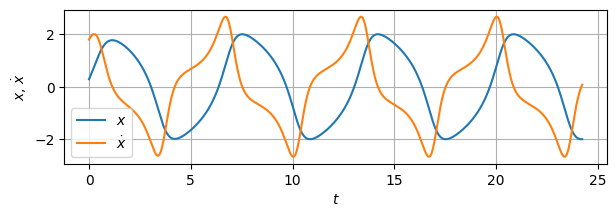

In [82]:
context = model.create_context()
context = context.with_continuous_state(x_opt)

recorded_signals = {"x": model.output_ports[0]}

options = SimulatorOptions(
    rtol=1e-12,
    atol=1e-14,
    max_minor_step_size=0.01,
    max_major_steps=1000,
    # max_minor_steps_per_major_step=10000,
)

results = collimator.simulate(
    model,
    context,
    (0.0, 50 * tf_opt),
    options=options,
    recorded_signals=recorded_signals,
)

t = results.time
x = results.outputs["x"]

plt.figure(figsize=(7, 2))
plt.plot(t, x[:, 0], label="$x$")
plt.plot(t, x[:, 1], label=r"$\dot{x}$")
plt.legend()
plt.xlabel("$t$")
plt.ylabel("$x$, $\dot{x}$")
plt.grid()
plt.show()

In [83]:
def forward_map(model, context, T, x0):
    context = context.with_continuous_state(x0)
    results = collimator.simulate(model, context, (0.0, T), options=shoot_options)
    return results.context.continuous_state


print(x_opt)
forward_map(model, context, tf_opt, x_opt)

collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=100, ode_solver_method=default, rtol=1e-12, atol=1e-14, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=False, recorded_signals=0, return_context=True), Dopri5Solver(system=VanDerPol(system_id=3, name=..., ui_id=None, parent=None), rtol=1e-12, atol=1e-14, max_step_size=None, min_step_size=None, method='default', enable_autodiff=True)


[0.28506755 1.80338085]


Array([1.22306068, 1.7739371 ], dtype=float64)

In [84]:
func = jax.jit(partial(forward_map, model, context, tf_opt))

# Jacobian of the forward map
# eigvals <= 1.0 indicate stability of the limit cycle
M = jax.jacrev(func)(x_opt)

floquet_multiploiers = np.linalg.eigvals(M)
print(f"{floquet_multiploiers=}")

collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=100, ode_solver_method=default, rtol=1e-12, atol=1e-14, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=False, recorded_signals=0, return_context=True), Dopri5Solver(system=VanDerPol(system_id=3, name=..., ui_id=None, parent=None), rtol=1e-12, atol=1e-14, max_step_size=None, min_step_size=None, method='default', enable_autodiff=True)


floquet_multiploiers=array([0.62920695+0.89012543j, 0.62920695-0.89012543j])


In [126]:
# Generate a valid initial condition using the reset map.
from scipy.interpolate import interp1d
xs = []
toes = []
ts = []

var_vals1 = np.linspace(-0.5, 0.5, 7)
var_vals2 = np.linspace(-1, 1, 7)

for var1 in tqdm(var_vals1):
    for var2 in var_vals2:
        x0 = jnp.array([var1, var2])
        context = context.with_continuous_state(x0)

        # Note we want to limit the major step length here to avoid skipping over the collision
        # options = SimulatorOptions(
        #     max_major_step_length=1.0,
        #     max_major_steps=500,
        #     atol=1e-14,
        #     rtol=1e-12,
        # )
        recorded_signals = {
            "x": model.output_ports[0],
        }
        results = collimator.simulate(
            model,
            context,
            (0.0, 100.0),
            options=options,
            recorded_signals=recorded_signals,
        )

        t = results.time
        x = results.outputs["x"]
        new_t = np.linspace(0, 100, 3000)
        new_x = np.zeros((new_t.shape[0], x.shape[1]))

        # Create an interpolation function using cubic spline
        
        for idx in range(x.shape[1]):
            interpolation_function = interp1d(t, x[:, idx], kind='cubic', fill_value='extrapolate')

            # Interpolate the values onto the new time vector
            new_x[:, idx] = interpolation_function(new_t)

        ts.append(t)
        xs.append(new_x)

  0%|          | 0/7 [00:00<?, ?it/s]collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=1000, ode_solver_method=default, rtol=1e-12, atol=1e-14, min_minor_step_size=None, max_minor_step_size=0.01, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=1, return_context=True), Dopri5Solver(system=VanDerPol(system_id=3, name=..., ui_id=None, parent=None), rtol=1e-12, atol=1e-14, max_step_size=0.01, min_step_size=None, method='default', enable_autodiff=False)
collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=1000, ode_solver_method=default, rtol=1e-12, atol=1e-14, min_minor_step_size=None, max_minor_step_size=0.01, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=1, return_context=True), Dopri5Solver(system=VanDerPol(system_id=3, name=..., ui_id=None, parent=None), rtol=1e-12, 

In [127]:
xs.shape

AttributeError: 'list' object has no attribute 'shape'

In [128]:
xs = np.array([x[:np.min([x.shape[0] for x in np.array(xs[:12] + xs[13:], dtype='object')]), :] for x in xs[:24] + xs[25:]])

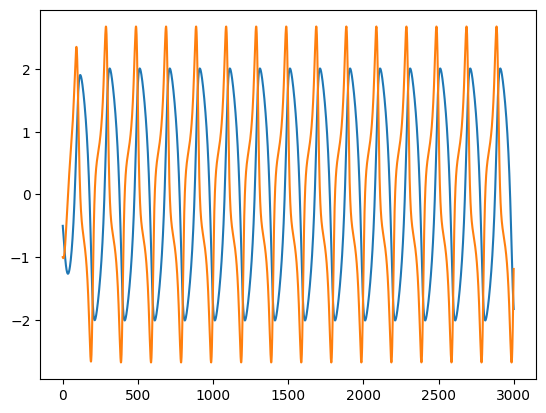

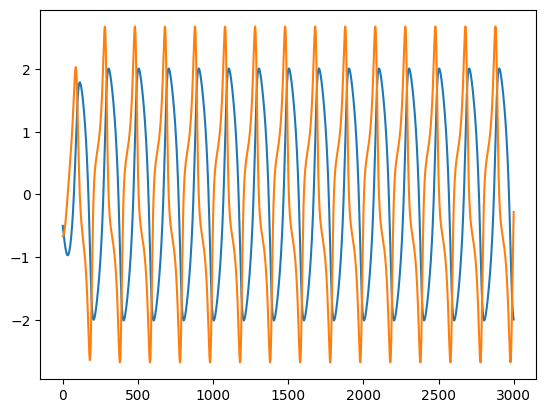

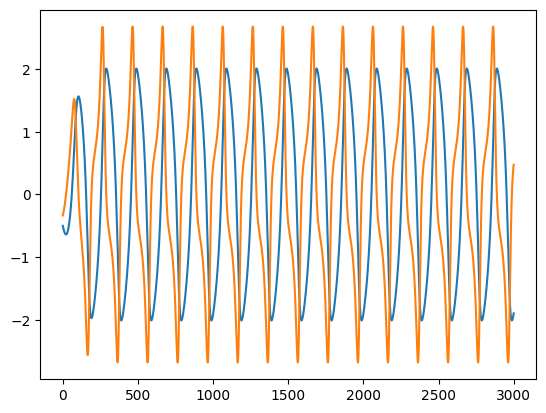

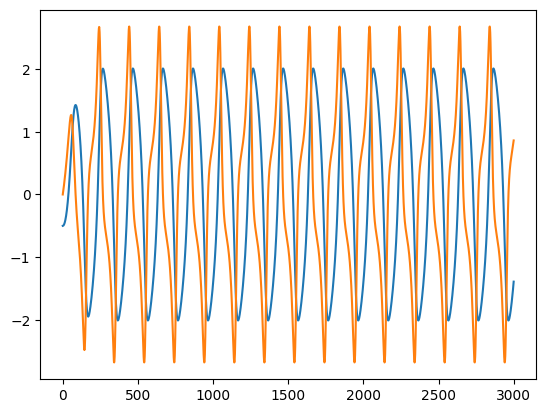

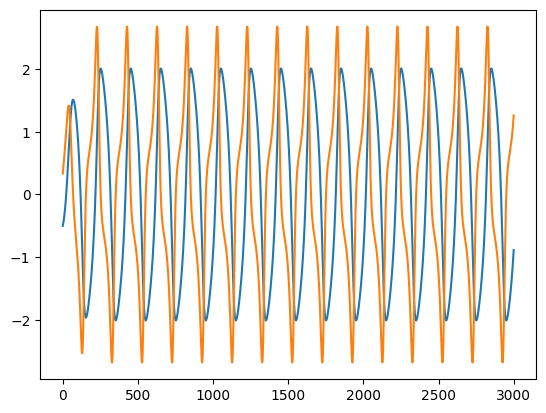

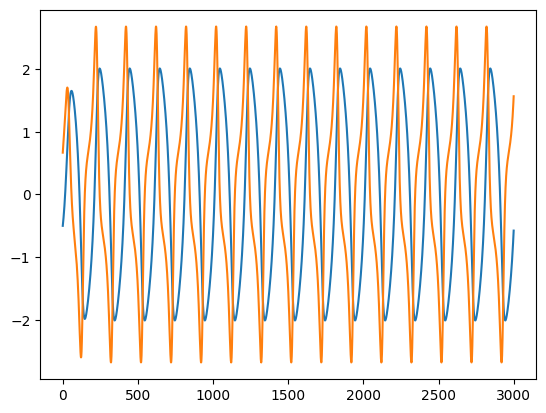

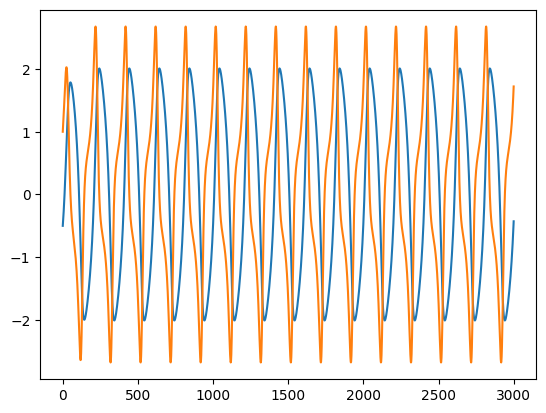

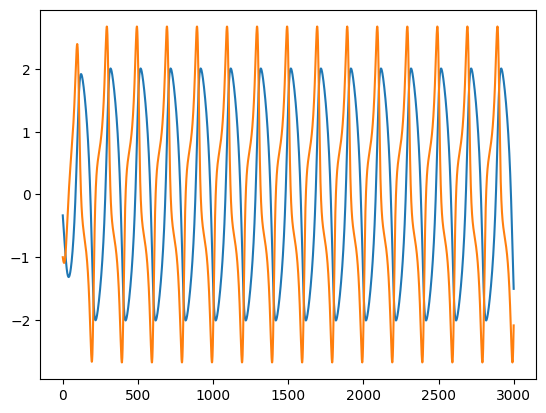

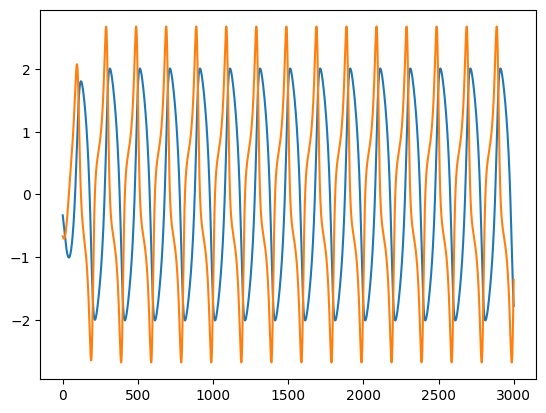

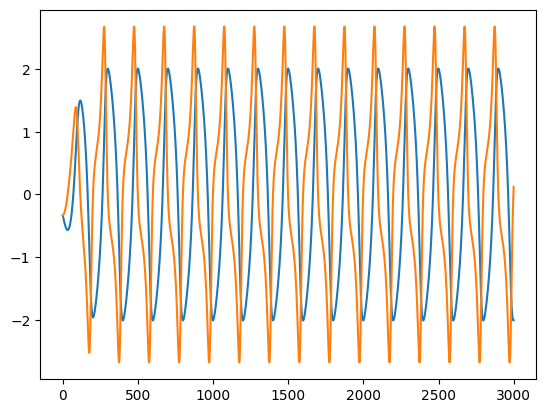

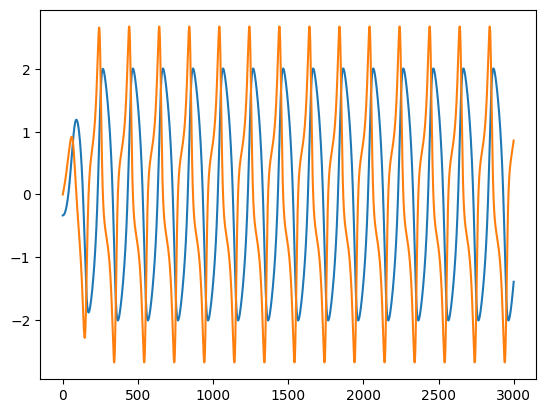

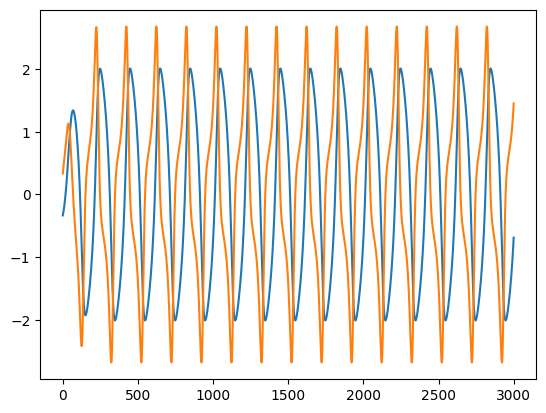

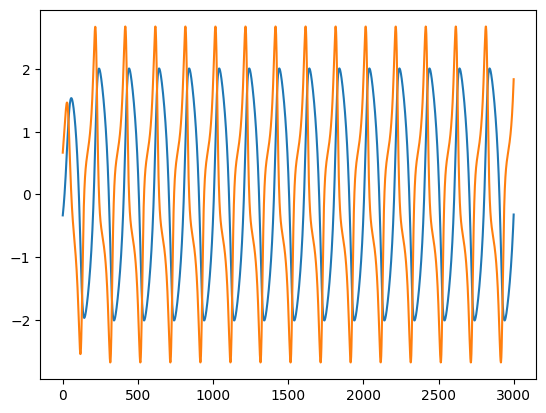

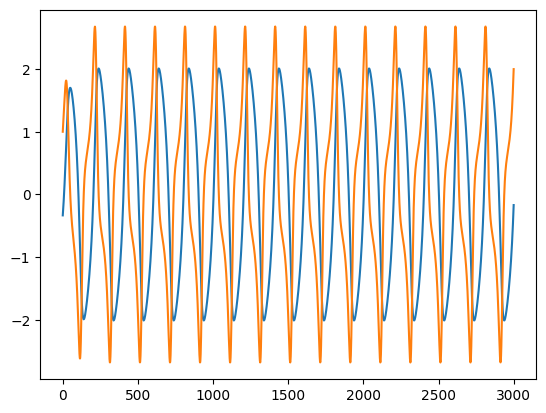

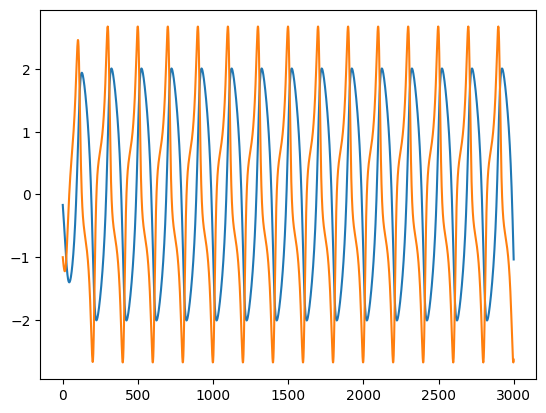

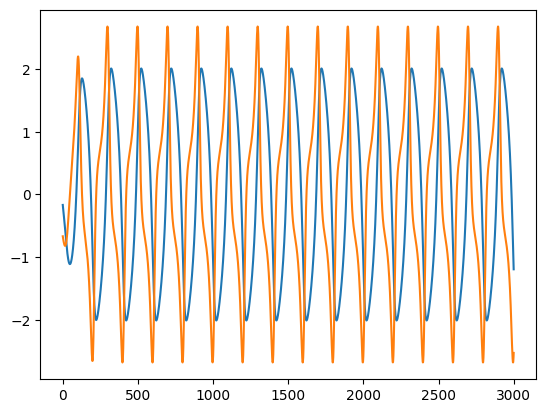

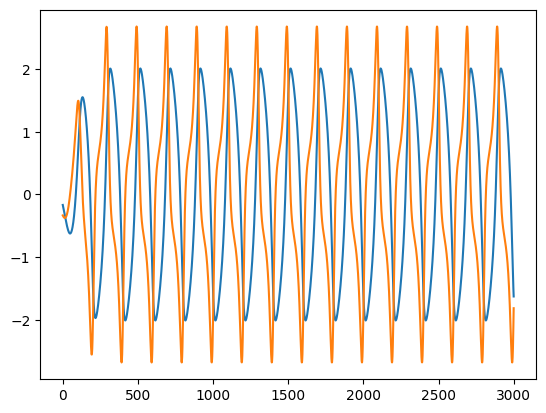

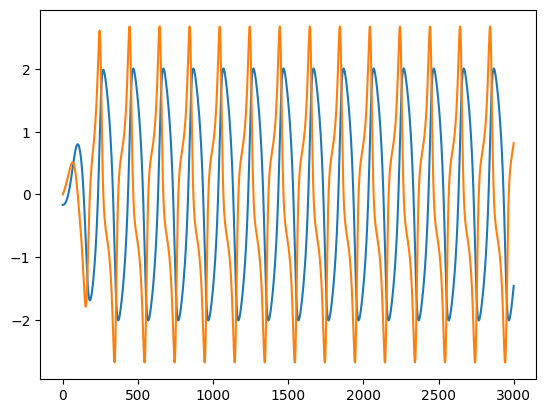

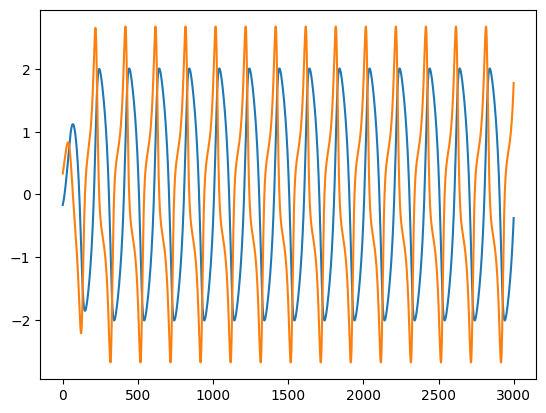

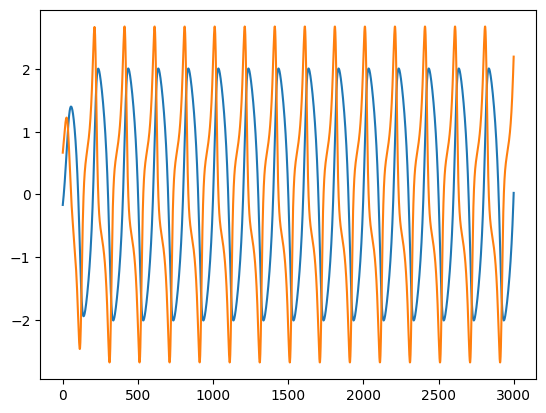

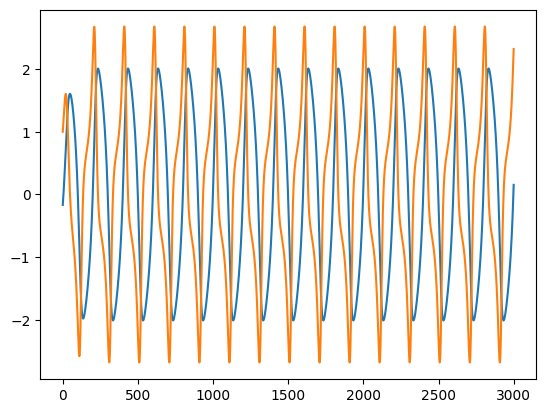

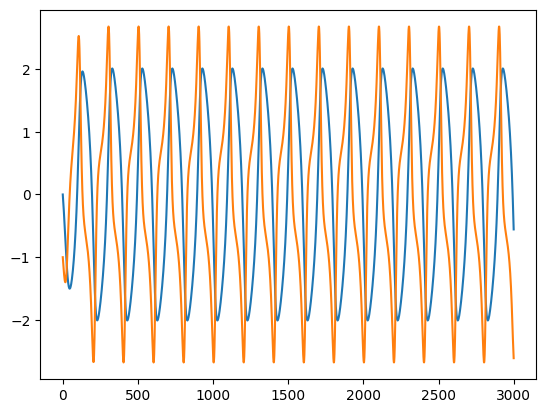

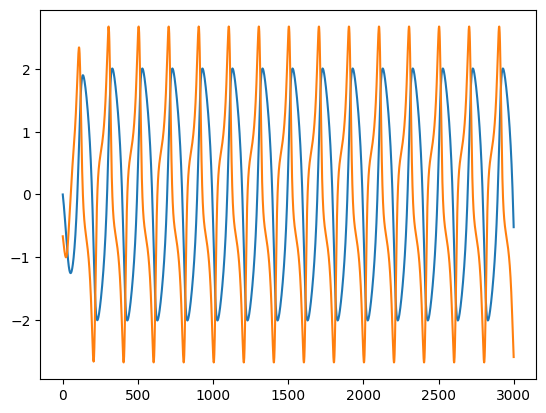

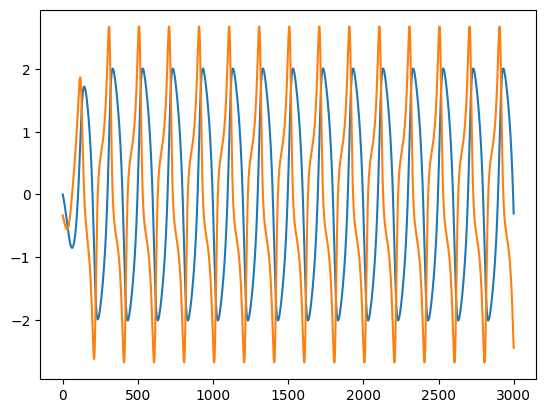

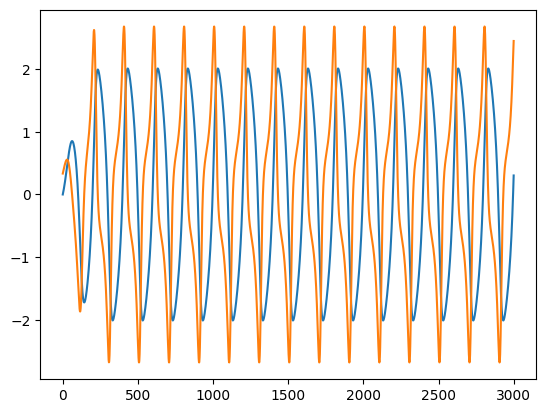

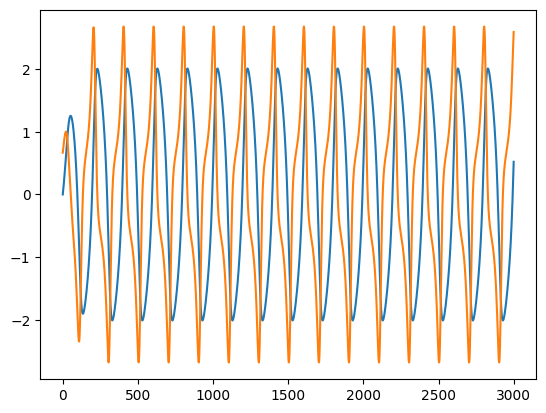

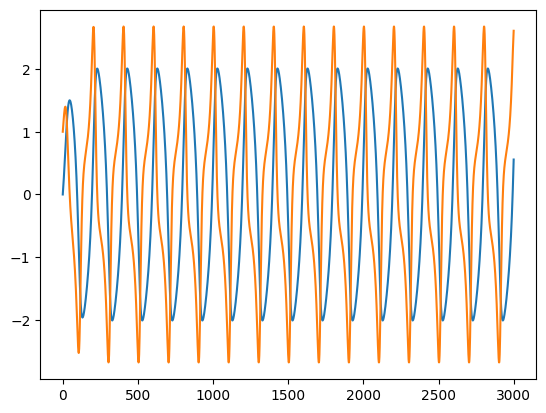

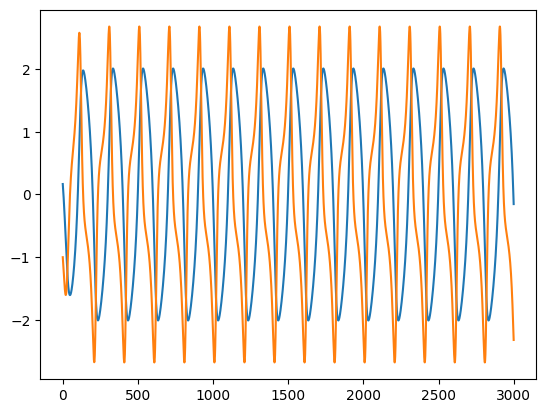

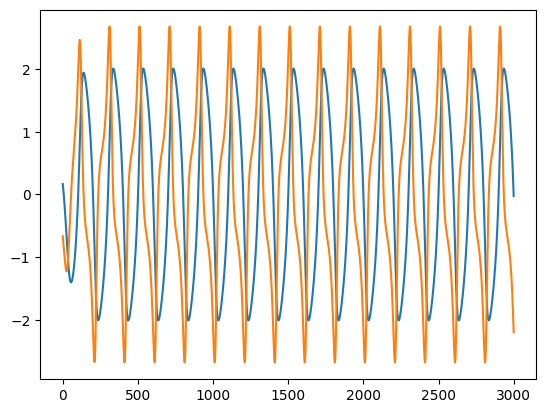

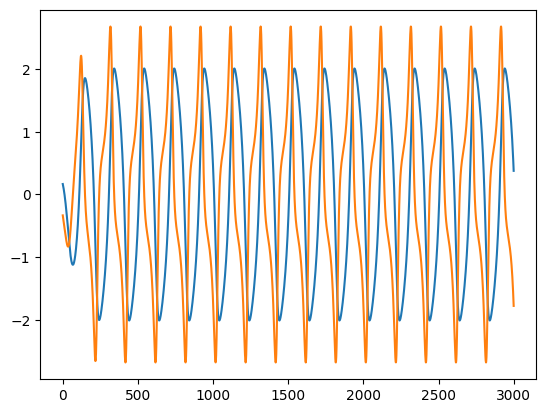

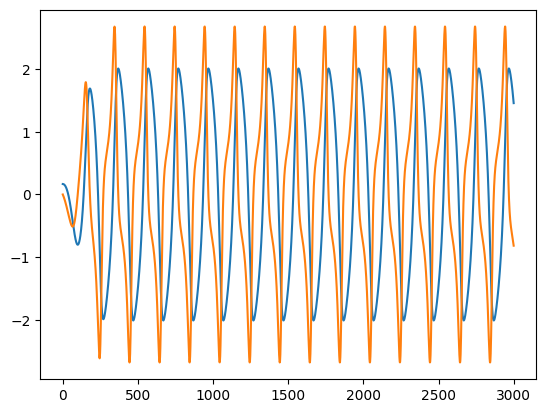

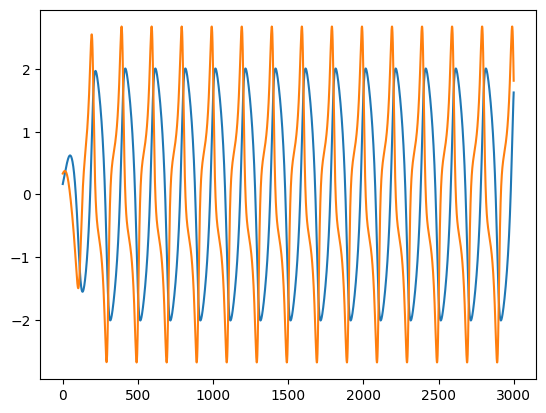

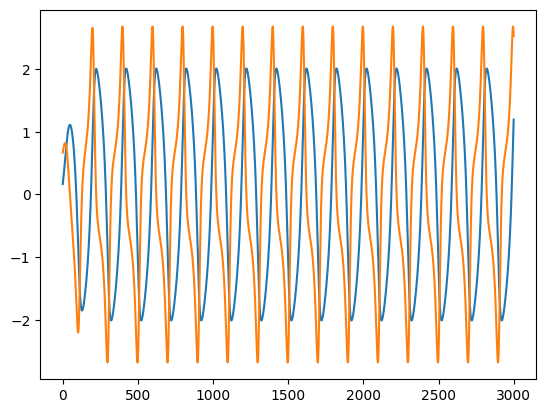

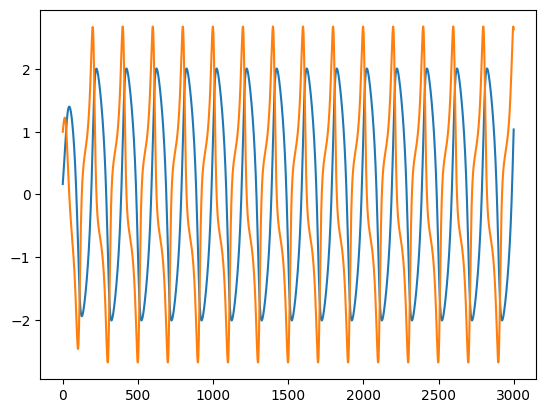

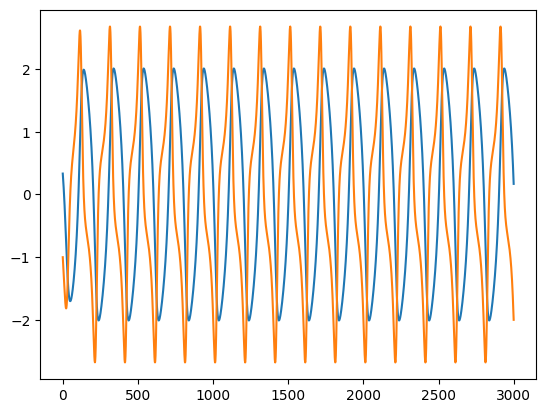

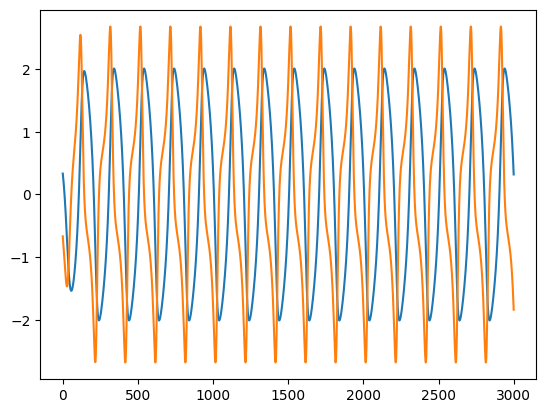

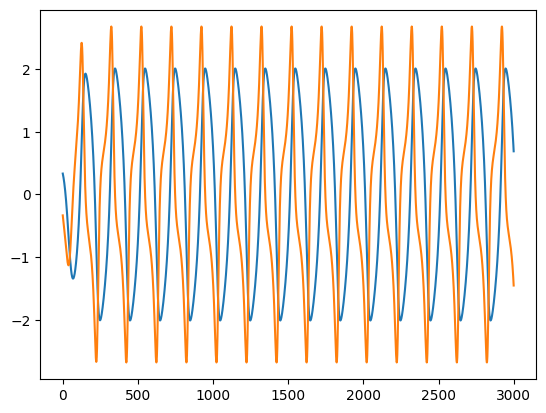

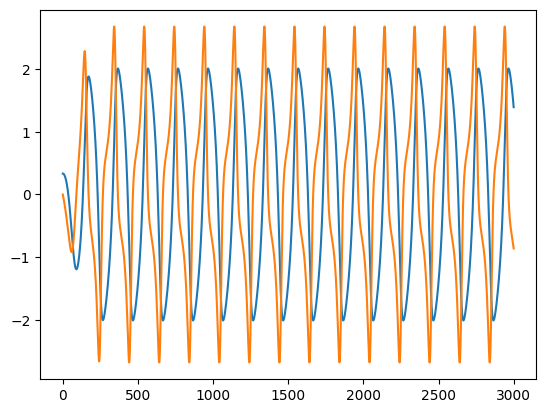

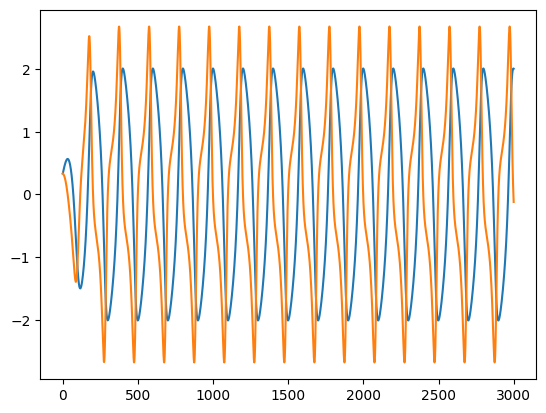

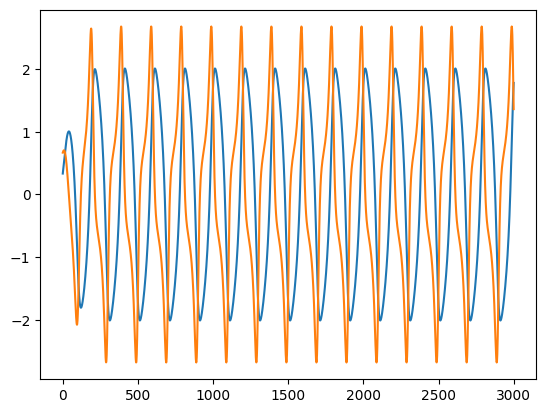

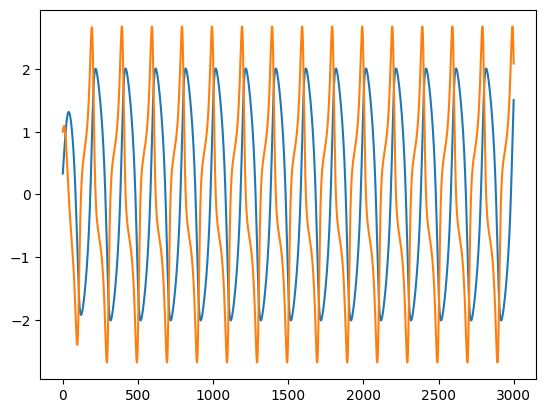

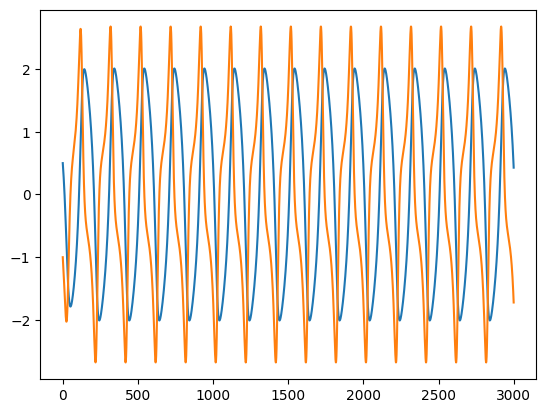

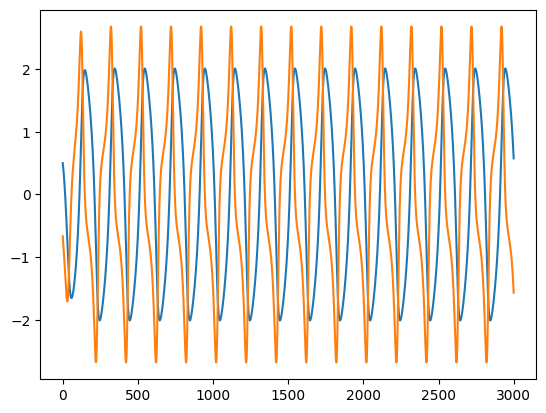

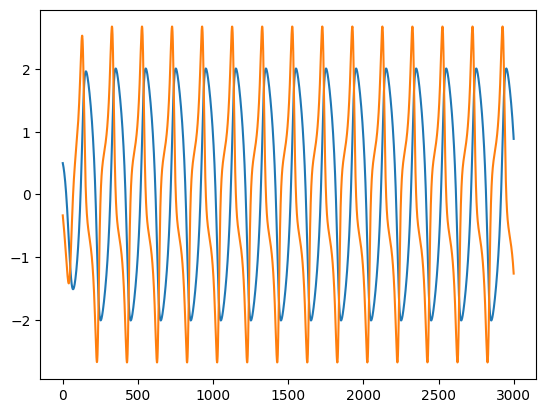

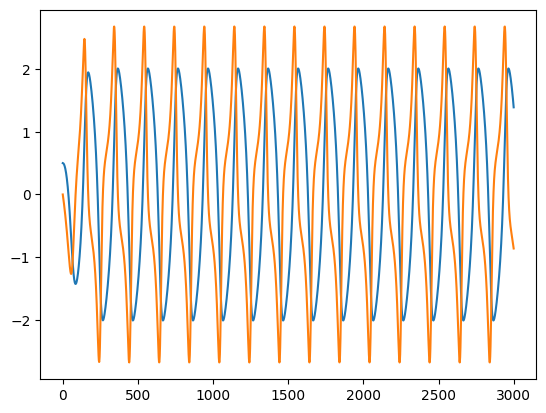

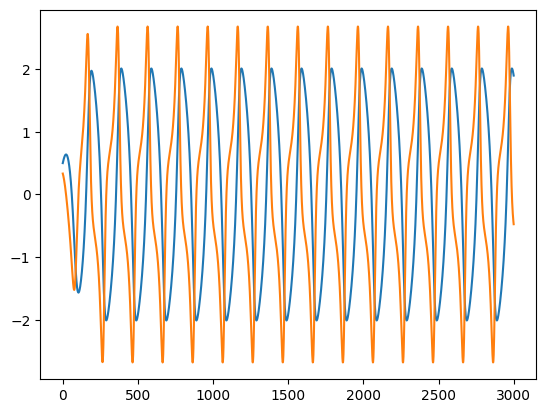

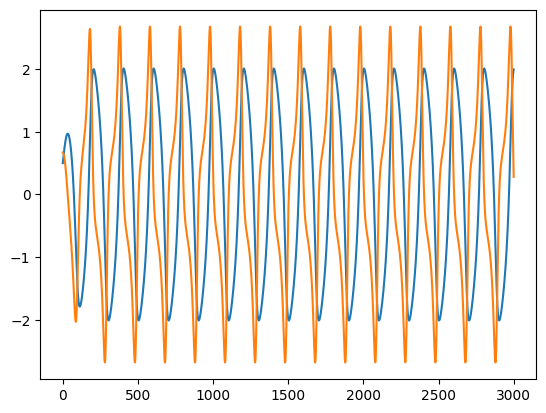

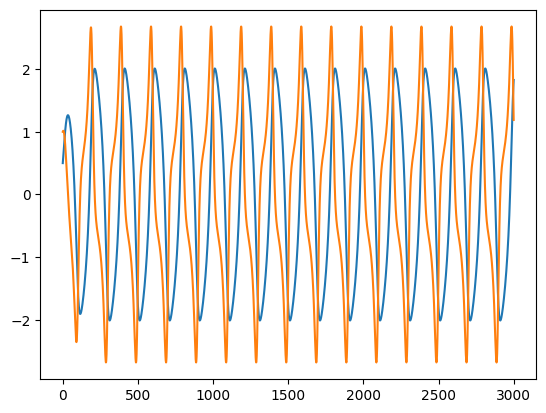

In [129]:
for x in xs:
    plt.plot(x)
    plt.show()

In [130]:
np.save("data/van_der_pol.npy", xs)